In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
import gensim.downloader as api
from sklearn.metrics import f1_score
import numpy as np
from gensim.models import KeyedVectors
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('Json Task1/NER_train.json', 'r') as f:
    task1_train_data = json.load(f)

with open('Json Task1/NER_val.json', 'r') as f:
    task1_val_data = json.load(f)

with open('Json Task1/NER_test.json', 'r') as f:
    task1_test_data = json.load(f)

with open('Json Task2/ATE_train.json', 'r') as f:
    task2_train_data = json.load(f)

with open('Json Task2/ATE_val.json', 'r') as f:
    task2_val_data = json.load(f)

with open('Json Task2/ATE_test.json', 'r') as f:
    task2_test_data = json.load(f)

with open('glove_embedding.pkl', 'rb') as pickle_file:
    glove_embeddings = pickle.load(pickle_file)
    
with open('fast_text_embedding.pkl', 'rb') as pickle_file:
    fast_text_embedding = pickle.load(pickle_file)

with open('word2vec_embeddings.pkl', 'rb') as pickle_file:
    word2vec_embeddings = pickle.load(pickle_file)

bio_mapping_task1 = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}
bio_mapping_task2 = {'O' : 0, 'I' : 1, 'B' : 2}

In [3]:
def pad_data():
    max_length = 84
    pad_word = 'PAD'

    data = [task1_train_data, task1_val_data, task1_test_data, task2_train_data, task2_val_data, task2_test_data]
    for task_data in data:
        remove_keys = []
        for key in task_data:
            words = task_data[key]['text'].split(' ')
            tags = task_data[key]['labels']
            if(len(words) >= max_length):
                remove_keys.append(key)
                continue
            else:
                for _ in range(len(words), max_length):
                    words.append(pad_word)
                    tags.append('O')   
            task_data[key]['text'] = ' '.join(words)
            task_data[key]['labels'] = tags
        
        for key in remove_keys:
            task_data.pop(key, None)



pad_data()
task1_train_data = {new_key: task1_train_data[old_key] for new_key, (old_key, _) in enumerate(task1_train_data.items())}
task1_val_data = {new_key: task1_val_data[old_key] for new_key, (old_key, _) in enumerate(task1_val_data.items())}
task1_test_data = {new_key: task1_test_data[old_key] for new_key, (old_key, _) in enumerate(task1_test_data.items())}
task2_train_data = {new_key: task2_train_data[old_key] for new_key, (old_key, _) in enumerate(task2_train_data.items())}
task2_val_data = {new_key: task2_val_data[old_key] for new_key, (old_key, _) in enumerate(task2_val_data.items())}
task2_test_data = {new_key: task2_test_data[old_key] for new_key, (old_key, _) in enumerate(task2_test_data.items())}



In [20]:

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(LSTMModel, self).__init__()
        # self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, 32, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(32, output_size)

    def forward(self, x):
        # x = self.embedding_layer(x)
        out, _ = self.lstm(x)
        out = self.fc1(out)
        return out
    
class Task_data(Dataset):
    def __init__(self, data, bio_index, embedding_type):
        self.data = data
        self.length = len(self.data)
        self.bio_index =  bio_index
        self.embedding_type = embedding_type

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        input_sequence = self.data[index]['text'].split(' ')
        sentence_embeddings = []
        if self.embedding_type == "glove":
            sentence_embeddings = [glove_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "word2vec":
            sentence_embeddings = [word2vec_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "fast_text":
            sentence_embeddings = [np.array(fast_text_embedding.get(word, np.zeros(300, dtype = 'float32')), dtype = 'float32') for word in input_sequence]

        sentence_embeddings = np.array(sentence_embeddings, dtype='float32')
        output_sequence = self.data[index]['labels']
        output_labels = [self.bio_index[word] for word in output_sequence]

        # output_labels = np.array(output_labels, dtype='float32')
        return torch.tensor(sentence_embeddings), torch.tensor(output_labels)

In [21]:
def train_model(task, embedding_type, model, optimizer, criterion, device,  num_epochs = 30, batch_size = 256):
    train_dataloader  = None
    val_dataloader  = None
    test_dataloader = None

    if task == 1:
        train_dataloader = DataLoader(Task_data(task1_train_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=True)
        val_dataloader =  DataLoader(Task_data(task1_val_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=True)
    elif task == 2:
        train_dataloader = DataLoader(Task_data(task2_train_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=True)
        val_dataloader =  DataLoader(Task_data(task2_val_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=True)


    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        all_train_predictions = []
        all_train_targets = []

        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            loss = 0
            # outputs[:, i, :].shape, 
            for i in range(outputs.size(1)):  # Iterate over time steps
                loss += criterion(outputs[:, i, :], targets[:, i])  
                # Apply CrossEntropyLoss at each time step
                # print(outputs[:, i, :].shape, targets[:, i].shape)
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            all_train_predictions.extend(outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_train_targets.extend(targets.view(-1).cpu().numpy())


        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        train_macro_f1 = f1_score(all_train_targets, all_train_predictions, average='macro')
        train_f1_scores.append(train_macro_f1)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Macro F1-Score: {train_macro_f1}")

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        all_val_predictions = []
        all_val_targets = []

        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)

                loss = 0
                for i in range(val_outputs.size(1)):  # Iterate over time steps
                    loss += criterion(val_outputs[:, i, :], val_targets[:, i])  

                total_val_loss += loss.item()

                all_val_predictions.extend(val_outputs.argmax(dim=2).view(-1).cpu().numpy())
                all_val_targets.extend(val_targets.view(-1).cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            val_macro_f1 = f1_score(all_val_targets, all_val_predictions, average='macro')
            val_f1_scores.append(val_macro_f1)
        print(f"Epoch {epoch + 1},  Validation Loss: {avg_val_loss}, Validation Macro F1-Score: {val_macro_f1}")
    plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores)

    return train_losses, train_f1_scores, val_losses, val_f1_scores

def plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Macro F1-Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, label='Training Macro F1-Score')
    plt.plot(epochs, val_f1_scores, label='Validation Macro F1-Score')
    plt.title('Training and Validation Macro F1-Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_test_results(test_loss, test_macro_f1):
    plt.figure(figsize=(6, 6))
    labels = ['Test Loss', 'Test Macro F1-Score']
    values = [test_loss, test_macro_f1]

    plt.bar(labels, values, color=['blue', 'green'])
    plt.title('Test Results')
    plt.ylabel('Values')
    plt.show()

def test_model(task, embedding_type, model, criterion, device, batch_size = 1):
    test_dataloader = None
    if task == 1:
        test_dataloader =  DataLoader(Task_data(task1_test_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=False)

    elif task == 2:
        test_dataloader =  DataLoader(Task_data(task2_test_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=False)

    total_test_loss = 0
    all_test_predictions = []
    all_test_targets = []

    with torch.no_grad():
        for test_inputs, test_targets in test_dataloader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
            test_outputs = model(test_inputs)

            loss = 0
            for i in range(test_outputs.size(1)):  # Iterate over time steps
                loss += criterion(test_outputs[:, i, :], test_targets[:, i])  

            total_test_loss += loss.item()

            all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_test_targets.extend(test_targets.view(-1).cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='macro')
    print(f'Test Loss: {avg_test_loss}, Test Macro F1-Score: {test_macro_f1}')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 1, embedding_type = "fast_text", model = model, num_epochs = 20, optimizer=optimizer, criterion=criterion, batch_size=128, device=device)
test_model(task = 1, embedding_type = "fast_text", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t1_lstm_fast_text.pt')

/Users/nalishjain/Acad Sem 6/NLP-Assignments/A2_16/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Training Loss: 259.63451398005253, Training Macro F1-Score: 0.02541135329971414
Epoch 1,  Validation Loss: 218.2693134654652, Validation Macro F1-Score: 0.03588353241859336


KeyboardInterrupt: 

In [ ]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores =  train_model(task = 1, embedding_type = "glove", model = model, optimizer=optimizer,criterion=criterion, device=device, batch_size=128)
test_model(task = 1, embedding_type = "glove", model = model, criterion=criterion, device=device)

torch.save(model, 'trained_models/t1_lstm_glove.pt')

In [ ]:
model = LSTMModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores =  train_model(task = 1, embedding_type = "word2vec", model = model, optimizer=optimizer, criterion=criterion, device=device, batch_size=128)
test_model(task = 1, embedding_type = "word2vec", model = model, criterion=criterion, device=device)

torch.save(model, 'trained_models/t1_lstm_word2vec.pt')

Epoch 1, Training Loss: 32.88364934921265, Training Macro F1-Score: 0.32919834423063704
Epoch 1,  Validation Loss: 12.702999114990234, Validation Macro F1-Score: 0.329410039232941
Epoch 2, Training Loss: 14.176207780838013, Training Macro F1-Score: 0.32919834423063704
Epoch 2,  Validation Loss: 13.475581169128418, Validation Macro F1-Score: 0.329410039232941
Epoch 3, Training Loss: 13.217607975006104, Training Macro F1-Score: 0.32919834423063704
Epoch 3,  Validation Loss: 11.15250015258789, Validation Macro F1-Score: 0.329410039232941
Epoch 4, Training Loss: 11.645171403884888, Training Macro F1-Score: 0.32919834423063704
Epoch 4,  Validation Loss: 11.869710922241211, Validation Macro F1-Score: 0.329410039232941
Epoch 5, Training Loss: 11.593944787979126, Training Macro F1-Score: 0.32919834423063704
Epoch 5,  Validation Loss: 10.461612701416016, Validation Macro F1-Score: 0.329410039232941
Epoch 6, Training Loss: 11.056324481964111, Training Macro F1-Score: 0.32919834423063704
Epoch 6,

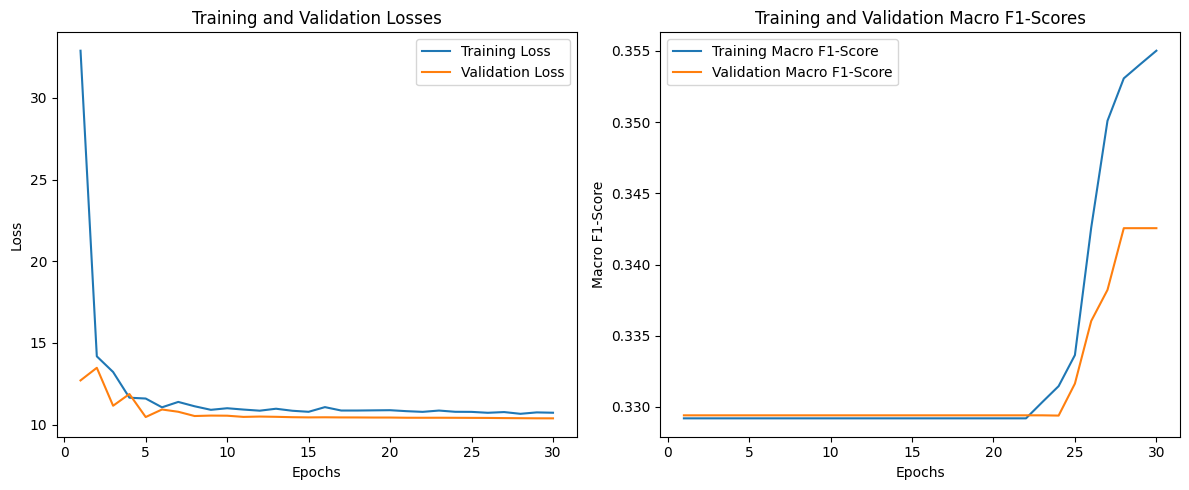

Test Loss: 10.955643563735777, Test Macro F1-Score: 0.3640673009694528


In [23]:
model = LSTMModel(300, 3).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 2, embedding_type = "fast_text", model = model, optimizer=optimizer, criterion=criterion, device=device, batch_size=256)

test_model(task = 2, embedding_type = "fast_text", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t2_lstm_fast_text.pt')

Epoch 1, Training Loss: 83.97104930877686, Training Macro F1-Score: 0.21158486168720844
Epoch 1,  Validation Loss: 35.63168716430664, Validation Macro F1-Score: 0.3316469599073793
Epoch 2, Training Loss: 18.82178783416748, Training Macro F1-Score: 0.33126691136283004
Epoch 2,  Validation Loss: 10.663588523864746, Validation Macro F1-Score: 0.329410039232941
Epoch 3, Training Loss: 11.829338073730469, Training Macro F1-Score: 0.32919834423063704
Epoch 3,  Validation Loss: 12.452418327331543, Validation Macro F1-Score: 0.329410039232941
Epoch 4, Training Loss: 13.321443557739258, Training Macro F1-Score: 0.32919834423063704
Epoch 4,  Validation Loss: 12.672761917114258, Validation Macro F1-Score: 0.329410039232941
Epoch 5, Training Loss: 12.973891735076904, Training Macro F1-Score: 0.32919834423063704
Epoch 5,  Validation Loss: 11.884099960327148, Validation Macro F1-Score: 0.329410039232941
Epoch 6, Training Loss: 12.243011474609375, Training Macro F1-Score: 0.32919834423063704
Epoch 6,

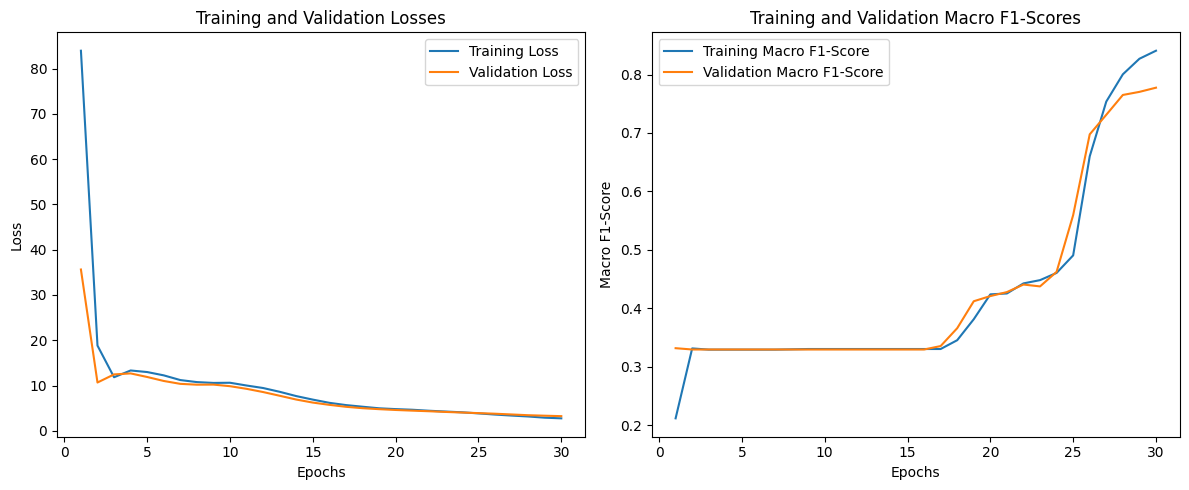

Test Loss: 3.5154749752908216, Test Macro F1-Score: 0.7672645547687633


In [27]:
model = LSTMModel(300, 3).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 2, embedding_type = "glove", model = model, optimizer=optimizer, criterion=criterion, device=device)
test_model(task = 2, embedding_type = "glove", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t2_lstm_glove.pt')

Epoch 1, Training Loss: 33.79465174674988, Training Macro F1-Score: 0.27948811121879524
Epoch 1,  Validation Loss: 13.571096420288086, Validation Macro F1-Score: 0.32941909816755127
Epoch 2, Training Loss: 12.77494192123413, Training Macro F1-Score: 0.3314172765684393
Epoch 2,  Validation Loss: 10.307709693908691, Validation Macro F1-Score: 0.329410039232941
Epoch 3, Training Loss: 10.953020811080933, Training Macro F1-Score: 0.32919834423063704
Epoch 3,  Validation Loss: 8.613473892211914, Validation Macro F1-Score: 0.329410039232941
Epoch 4, Training Loss: 7.769367694854736, Training Macro F1-Score: 0.32919834423063704
Epoch 4,  Validation Loss: 6.141071319580078, Validation Macro F1-Score: 0.329410039232941
Epoch 5, Training Loss: 6.093032479286194, Training Macro F1-Score: 0.32919834423063704
Epoch 5,  Validation Loss: 5.132766246795654, Validation Macro F1-Score: 0.329410039232941
Epoch 6, Training Loss: 5.429137110710144, Training Macro F1-Score: 0.33172655267086193
Epoch 6,  Val

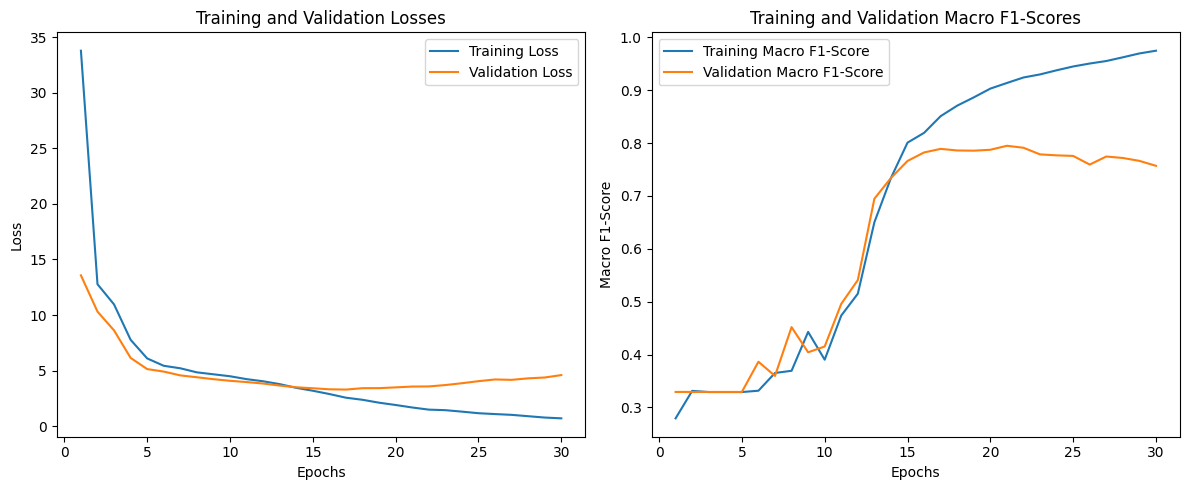

Test Loss: 5.090100589764827, Test Macro F1-Score: 0.7526031794787827


In [25]:
model = LSTMModel(300, 3).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 2, embedding_type = "word2vec", model = model, num_epochs=30,optimizer=optimizer, criterion=criterion, device=device)
test_model(task = 2, embedding_type = "word2vec", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t2_lstm_word2vec.pt')